# Mushroom Habitat Prediction through a Multinomial Logistic Regression Analysis of Specimen Characteristics
### By: Lucas L. Boyd

---

# Project Overview

The organanizational need that was addressed in this project was to build a model that could accurately predict the habitat of a mushroom specimen based on recorded observations. The project specifically entailed creating a data manipulation pipeline and data model; the scope of the project did not include any secondary integration of the model into a customer-facing application, or any other work or support after the creation of the model and pipeline.

The end result of the project is a Multinomial Logistic Regression model that ingests five categorical variables and uses them to predict the habitat of the specimen in question. This model was coded in a Python Jupyter notebook and utilized a number of libraries for the data massaging and model creation, with much of the work being done using the following libraries: Pandas, SciKit Learn, Imbalanced Learning, and MatPlotLib.


In [37]:
# Import statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import joblib

In [38]:
# Data dictionary just for my own sanity

data_dict = {'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 's': 'sunken', 'p': 'spherical', 'o': 'others'},
             'cap-surface': {'i': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth', 'd': 'dry', 'h': 'shiny', 'l': 'leathery', 'k': 'sikly', 
                             't': 'sticky', 'w': 'wrinkled', 'e': 'fleshy'},
             'stem-root': {'b': 'bulbous', 's': 'swollen', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rizhomorphs', 'r': 'rooted'},
             'ring-type': {'c': 'cobwebby', 'e': 'evanexcent', 'r': 'flaring', 'g': 'grooved', 'l': 'large', 'p': 'pendant', 's': 'sheathing', 
                           'z': 'zone', 'y': 'scaly', 'm': 'movable', 'f': 'none', '?': 'unknown'},
             'season': {'s': 'spring', 'u': 'summer', 'a': 'autumn', 'w': 'winter'},
             'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'h': 'heaths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}}

In [39]:
# Reading in data from CSV

mushroom_baseDF= pd.read_csv('mushroom_overload.csv', low_memory=False)

In [40]:
# Getting a look at the different columns available

print(f"Columns: {mushroom_baseDF.columns}", "\n")
print(f"DataFrame shape: {mushroom_baseDF.shape}")

Columns: Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object') 

DataFrame shape: (6723116, 21)


In [41]:
# Simple for loop to output the number of null values in each feature

for i in mushroom_baseDF.columns:
    print(f"Number of null-values in {i}: {mushroom_baseDF[i].isnull().sum().sum()}")

Number of null-values in class: 0
Number of null-values in cap-diameter: 0
Number of null-values in cap-shape: 0
Number of null-values in cap-surface: 1579337
Number of null-values in cap-color: 0
Number of null-values in does-bruise-or-bleed: 0
Number of null-values in gill-attachment: 1066721
Number of null-values in gill-spacing: 2800709
Number of null-values in gill-color: 0
Number of null-values in stem-height: 0
Number of null-values in stem-width: 0
Number of null-values in stem-root: 5763499
Number of null-values in stem-surface: 4263506
Number of null-values in stem-color: 0
Number of null-values in veil-type: 6367343
Number of null-values in veil-color: 5893024
Number of null-values in has-ring: 0
Number of null-values in ring-type: 276729
Number of null-values in spore-print-color: 6049365
Number of null-values in habitat: 0
Number of null-values in season: 0


In [42]:
# Slimming down the dataframe into a new one to only have the relavent data

mushroom_DF = mushroom_baseDF[['cap-shape', 'cap-surface', 'stem-root', 'ring-type', 'season', 'habitat']]
mushroom_DF.head()

,cap-shape,cap-surface,stem-root,ring-type,season,habitat
0,f,g,s,g,a,d
1,x,h,s,g,u,d
2,f,h,s,p,a,d
3,f,g,s,g,u,d
4,x,h,s,p,w,d


In [43]:
'''
Dropping all rows with null values. Since I am testing if the selected categorical variables can be used to predict the dependent variable,
I am only interested in rows in which all variables are filled out.
'''

mushroom_DF_cleaned = mushroom_DF.dropna(axis = 0, how = 'any')

In [44]:
# Checking the shape

mushroom_DF_cleaned.shape

(643352, 6)

In [45]:
# Checking again for null values

for i in mushroom_DF_cleaned.columns:
    print(f"Number of null-values in {i}: {mushroom_DF_cleaned[i].isnull().sum().sum()}")

Number of null-values in cap-shape: 0
Number of null-values in cap-surface: 0
Number of null-values in stem-root: 0
Number of null-values in ring-type: 0
Number of null-values in season: 0
Number of null-values in habitat: 0


In [46]:
# Breaking the DataFrame into independent and dependent variables

X = mushroom_DF_cleaned[['cap-shape', 'cap-surface', 'stem-root', 'ring-type', 'season']]
y = mushroom_DF_cleaned[['habitat']]

In [47]:
# Using label encoding on the dependent variable and printing out the encoding mapping.

label_encoder = LabelEncoder()
y.loc[:, 'habitat'] = label_encoder.fit_transform(y['habitat']) 
print("Original categories and their encoded values:", dict(enumerate(label_encoder.classes_)))

Original categories and their encoded values: {0: 'd', 1: 'g', 2: 'h', 3: 'l', 4: 'm'}


habitat
0    475778
4     68990
3     49271
1     29625
2     19688
Name: count, dtype: int64


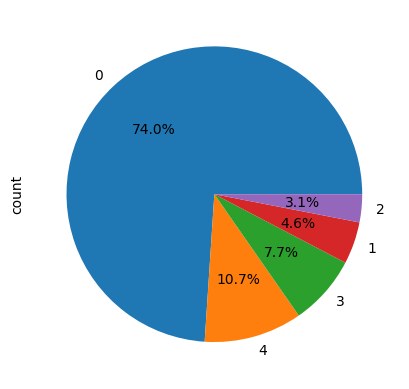

In [48]:
'''
Looking at the y-value spread. 0, which corresponds to d;woods, is highly overrepresented.
I found this while trying to fit the model originally, and had to perform more preprocessing.
'''

print(y['habitat'].value_counts())
y['habitat'].value_counts().plot.pie(autopct='%1.1f%%');

In [49]:
''' 
Flattens dataframe into 1-D array and makes sure values are INT. This is another issue I ran into while trying to fit the model.
The flattening was just to fix a warning, but for some reason the encoder was not changing the dtype of everything, causing an issue. I carte-blanch
changed everything to INT to make it all discrete values. This also needs to be done before the following UnderSampling because the undersampler will 
complain about the same issue as the model.
'''

y = y[['habitat']].values.flatten()
y = y.astype(int)

In [50]:
# Undersampling the data to cut everything down to the size of the minority label
rus = RandomUnderSampler(sampling_strategy='not minority')
X, y = rus.fit_resample(X, y)

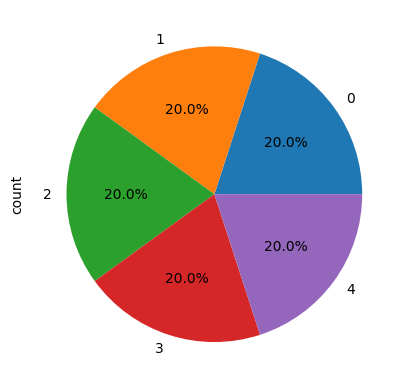

In [51]:
# Looking at the spread of the data another time to make sure that all is even.

y_series = pd.Series(y)
y_series.value_counts().plot.pie(autopct='%1.1f%%');

In [56]:
# Creating K-folds and splitting data

kf = KFold(n_splits=10, shuffle=True, random_state=42)
data_split_object = kf.split(X_array, y)

In [57]:
# Just visualizing the split

my_split_data = next(data_split_object)
print("Train indicies are: ", my_split_data[0][0:10])
print("Test indicies are: ", my_split_data[1][0:10])

Train indicies are:  [0 1 2 3 4 5 6 7 8 9]
Test indicies are:  [ 23  53  70  87  97 101 102 103 106 114]


In [58]:
# Empty lists are going to store accuracy values. The model dictionary will store the models for each K-fold.

predicted_y = []
expected_y = []
fold_accuracy= []
models = {}

In [59]:
'''
This FOR loop is doing a number of things:
    1. Creates the training and testing data-split off the data from each fold.
    2. Fit the model off the train data.
    3. Predicts the label from X_test using the trained model.
    4. Compares the predicted with the actual value in y_test.
    5. Saves the predicted and expected to the respective lists.
'''

for train_index, test_index in kf.split(X_array, y):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y[train_index], y[test_index]


    classifier = LogisticRegression(solver='saga', random_state=42)
    classifier.fit(X_train, y_train)

    predicted_this_fold = classifier.predict(X_test)

    # Leaving this in since I was using this to troubleshoot unbalanced data
    #print("y_test unique values:", np.unique(y_test), "Type:", type(y_test[0]))
    #print("predicted_this_fold unique values:", np.unique(predicted_this_fold), "Type:", type(predicted_this_fold[0]))

    accuracy = accuracy_score(y_test, predicted_this_fold)
    print("Accuracy from this fold is: " + accuracy.__str__())

    predicted_y.extend(predicted_this_fold)
    expected_y.extend(y_test)
    fold_accuracy.append(accuracy)
    models.update({classifier: accuracy})

Accuracy from this fold is: 0.8708858187728565
Accuracy from this fold is: 0.8693620479479887
Accuracy from this fold is: 0.8760666395774076
Accuracy from this fold is: 0.8813490451036164
Accuracy from this fold is: 0.8776919951239334
Accuracy from this fold is: 0.869869971556278
Accuracy from this fold is: 0.866822429906542
Accuracy from this fold is: 0.8688541243396993
Accuracy from this fold is: 0.8729175132060139
Accuracy from this fold is: 0.8763713937423812


In [60]:
# Final thing is to calculate and print the accuracy score for all folds.

accuracy = accuracy_score(expected_y, predicted_y)
print('\n', "Average accuracy from all folds is: " + accuracy.__str__())


 Average accuracy from all folds is: 0.8730190979276716


In [61]:
# Identifies the top performing model from the K-folds model dictionary and then exports it as a serialized object with joblib.
model_max = max(models, key= lambda x: models[x])
joblib.dump(model_max, "final_model.sav")

['final_model.sav']

### Final analysis graphs

Below are two graphs that are part of the final analysis. The model has already been exported in the above cell, but this gives more detail as to the performance of the best performing model. From the first graph, you can see the actual value differences between individual K-folds. In the graph after it you can see the pecentage differences between each run and how it compared to the baseline. The model for fold 4 approaches a 1% improvement on the habitat categorization over the average baseline value.

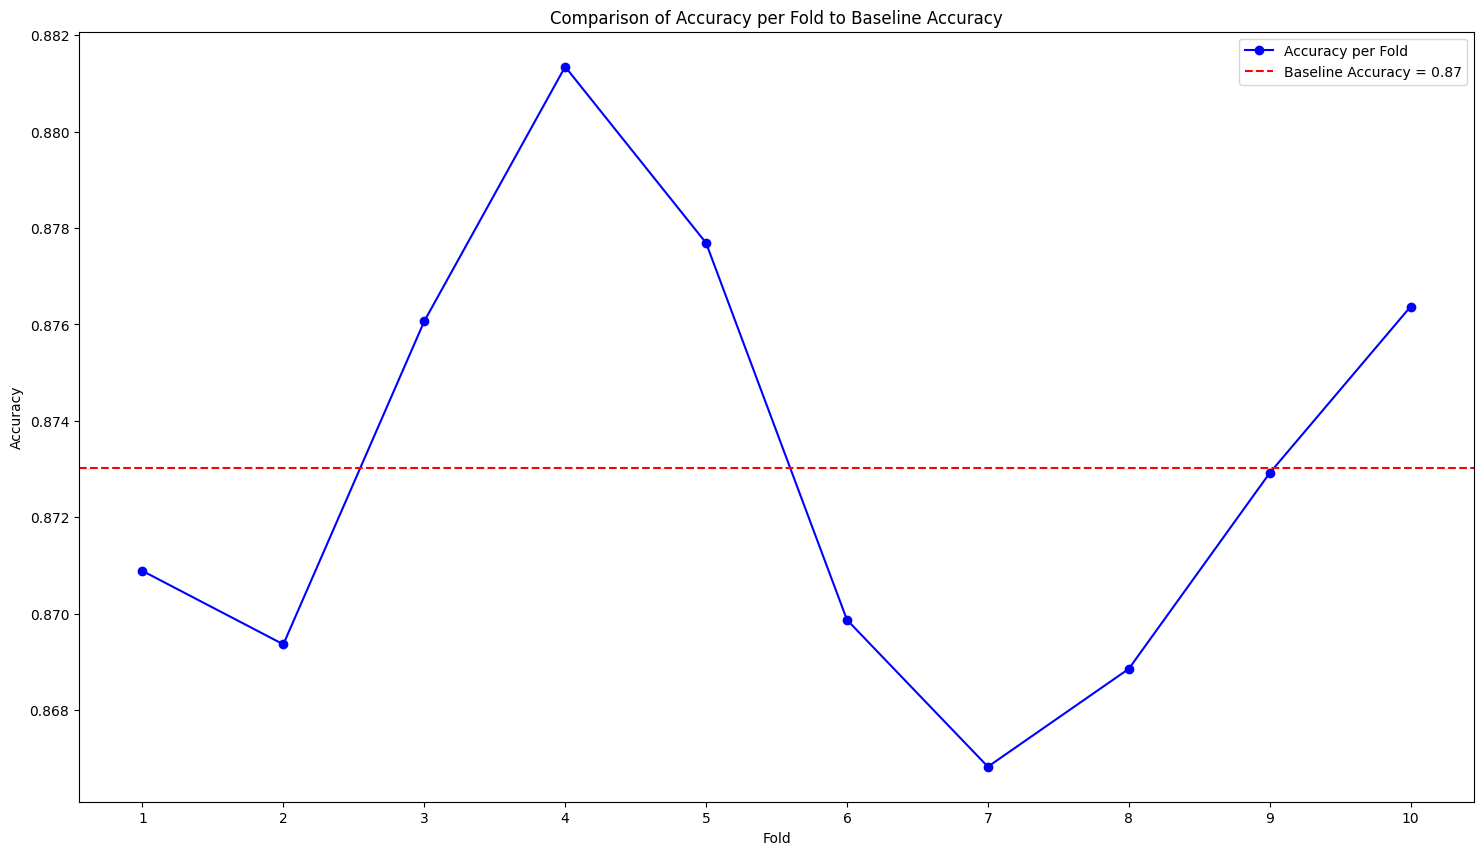

In [62]:
plt.figure(figsize=(18, 10))
# Creating the range for the tickmarks
fold_numbers = range(1, len(fold_accuracy) + 1)

# Plotting the values in accuracy_fold and the accuracy value as the baseline.
plt.plot(fold_numbers, fold_accuracy, marker='o', linestyle='-', color='b', label='Accuracy per Fold')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Baseline Accuracy = {accuracy:.2f}')



plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy per Fold to Baseline Accuracy')
plt.xticks(fold_numbers)
plt.legend()
plt.show()

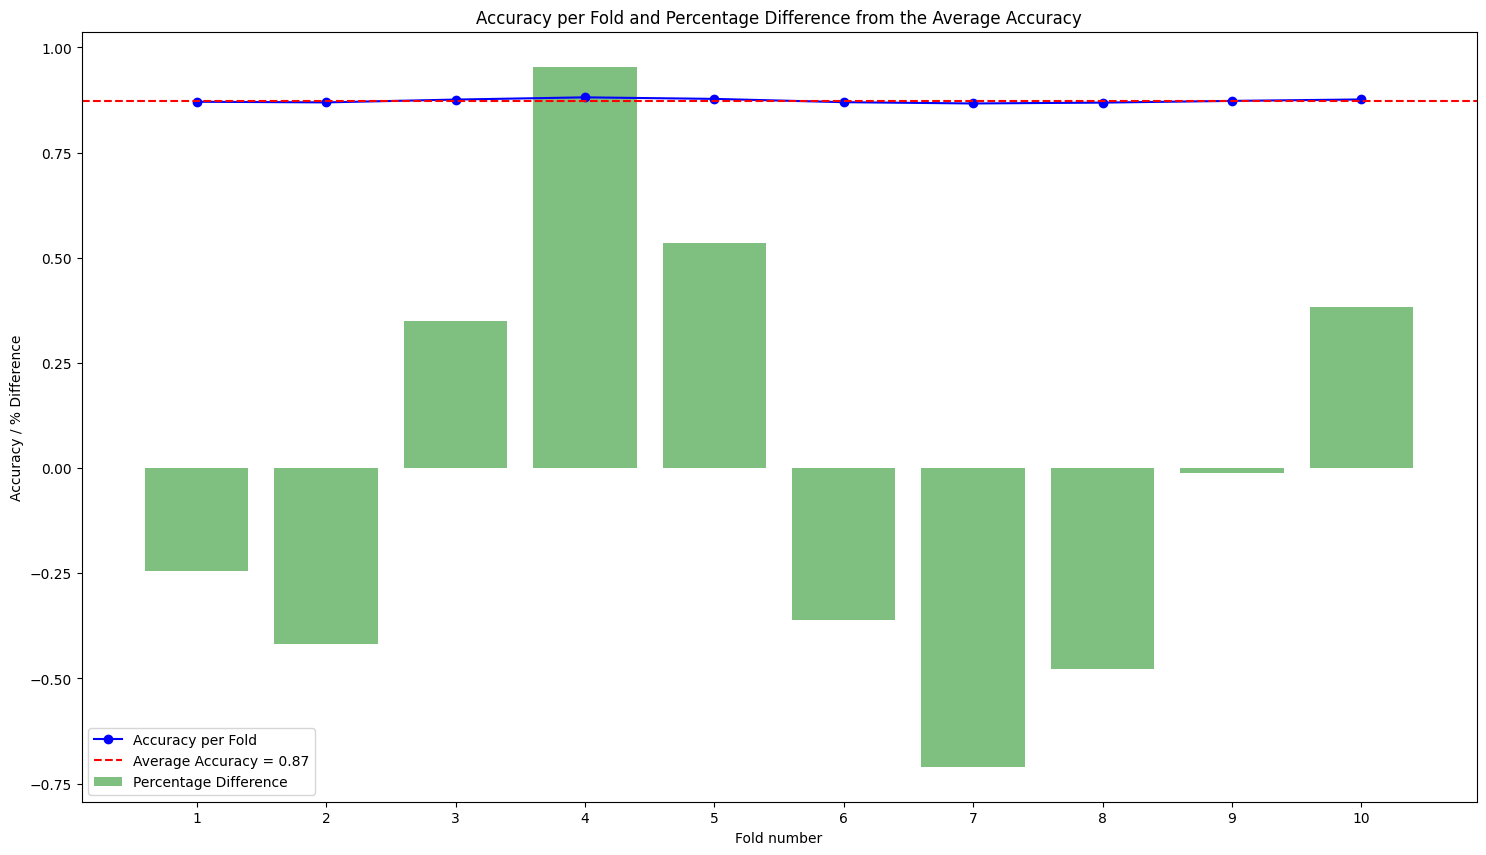

In [63]:
plt.figure(figsize=(18, 10))

# Calculating the average accuracy and the percentage diff from the average
average_accuracy = sum(fold_accuracy) / len(fold_accuracy)
percentage_diff = [(acc - average_accuracy) / average_accuracy * 100 for acc in fold_accuracy]

# Plotting the values in accuracy_fold and the average accuracy as horizontal base-line
plt.plot(range(1, len(fold_accuracy) + 1), fold_accuracy, marker='o', linestyle='-', color='b', label='Accuracy per Fold')
plt.axhline(y=average_accuracy, color='r', linestyle='--', label=f'Average Accuracy = {average_accuracy:.2f}')

# Plotting the percentage differences as a bar chart
plt.bar(range(1, len(percentage_diff) + 1), percentage_diff, color='g', alpha=0.5, label='Percentage Difference')



plt.xlabel('Fold number')
plt.ylabel('Accuracy / % Difference')
plt.title('Accuracy per Fold and Percentage Difference from the Average Accuracy')
plt.xticks(ticks=range(1, len(fold_accuracy) + 1))
plt.legend()
plt.show()

# Conclusion
The model created for the project was created on the following parameters:

---

Model type: Supervised Regression

Model algorithm: Multinomial Logistic Regression

Performance metrics: Accuracy score calculated from Sci-Kit learn metrics

Benchmark: Accuracy score >= .80 

---

The model proved statistically significant in the trials since it achieved a prediction accuracy score greater than 80%. All models trained for the K-folds performed greater than this threshold, with the top performing model performing with a 88.13% accuracy. This supports the hypothesis that a multinomial logistic regression model, trained on the physical characteristics of mushrooms, can provide a reliable method for predicting mushroom habitats with at least 80% accuracy.

The model also provides practical significance since it can be used to accurately predict the habitat of a mushroom, and will be highly useful to research teams. This will allow them to complete incorrect data and will also allow them to asses the locations they wish to visit for field research.
